# The pyabf Cookbook: Bells and Whistles
_A collection of code examples demonstrating most of the features built into the `pyabf.ABF` class._

For more resources, see the pyABF project website: http://www.GitHub.com/swharden/pyABF

## Preparing the Environment

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
np.set_printoptions(precision=3)
sys.path.insert(0, '../src/')

## Instantiating the ABF class
Typically we instantiate an ABF class by giving it a path to an ABF(string):

In [2]:
import pyabf
abf=pyabf.abf.ABF("../data/17o05026_vc_stim.abf")

Alternatively, you can also instantiate the ABF class by giving it an existing ABF class object:
* This allows you to modify ABF classes differently. This should be used sparingly, as it doubles the amount of memory used.
* This also allows you to write functions which can accept a path or an ABF object, assuming the first line instantiates the ABF object with the received argument.
* This is an easy way to reset all values to their default values


In [3]:
abf.gaussianSigma=123
print(abf.gaussianSigma)
abf=pyabf.ABF(abf) # reset to defaults
print(abf.gaussianSigma)

123
0


## Quick access to help
```python
abf.help() # launches the pyABF project page in a web browser
```

## Seeing what methods are available

Want to use a feature but can't remember what it was called? The `abf.info()` function lists all public properties of the ABF object:

In [4]:
abf.info();


### INSTANTIATION ###
abf=pyabf.ABF(R'C:\Users\scott\Documents\GitHub\pyABF\data\17o05026_vc_stim.abf')

### VALUES ###
* abf.ID = 17o05026_vc_stim
* abf.colormap = jet_r
* abf.commandHold = -50.0
* abf.dataChannels = 1
* abf.dataSweepSelected = 0
* abf.epochCount = 3
* abf.experimentLengthSec = 80.0
* abf.filename = C:\Users\scott\Documents\GitHub\pyABF\data\17o05026_vc_stim.abf
* abf.gaussianLeft = False
* abf.gaussianRight = True
* abf.gaussianSigma = 0
* abf.mode = VC
* abf.pointDurMS = 0.05
* abf.pointDurSec = 5e-05
* abf.pointsPerMS = 20.0
* abf.pointsPerSec = 20000.0
* abf.pointsPerSweep = 200000
* abf.sweepCount = 8
* abf.sweepLengthSec = 10.0
* abf.sweepPointCount = 200000
* abf.sweepSelected = 0
* abf.units = pA
* abf.unitsCommand = mV
* abf.unitsCommandLong = Command Potential (mV)
* abf.unitsLong = Membrane Current (pA)
* abf.unitsTime = seconds
* abf.unitsTimeLong = Signal Time (seconds)

### LISTS ###
* abf.commandHoldingByDAC = [-50.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

## Negative sweeps
Negative sweep numbers counts backward from the last sweep:
```python
abf.setSweep(0) # first sweep
abf.setSweep(1) # second sweep
abf.setSweep(-1) # last sweep
abf.setSweep(-2) # second to last sweep
```

## Lowpass (Gaussian) filtering of signal data
Gausian filtering uses a "filter width" (sigma) to smooth signal data. This value (in data points) is stored in `abf.gaussianSigma`. 

_I usually use `abf.gaussianSigma=abf.pointsPerMS/4_

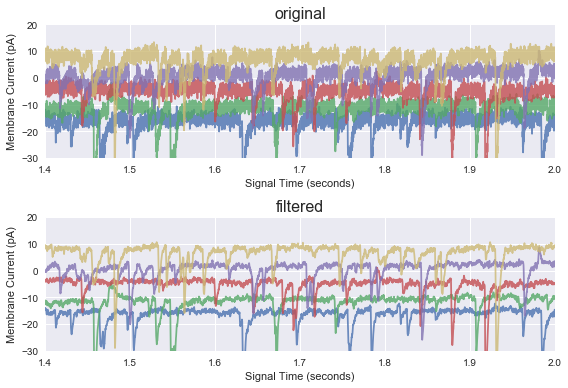

In [5]:
def plotSomeSweeps(title,axis=[1.4,2,-30,20]):
    for sweepNumber in range(5):
        abf.setSweep(sweepNumber)
        plt.plot(abf.dataX,abf.dataY+sweepNumber*6,alpha=.8)
    abf.plotDecorate(title=title,axis=axis)

# Without filtering
ax1=plt.subplot(211)
abf.gaussianSigma=0 # this is 0 (disabled) by default
plotSomeSweeps("original")

# With filtering
ax2=plt.subplot(212,sharex=ax1,sharey=ax1)
abf.gaussianSigma=abf.pointsPerMS/4 # I like this value
plotSomeSweeps("filtered")

### Choosing a sigma value
It is recommended that you write code using sigma as a function of `abf.pointsPerMS` rather than a fixed number. This will cause sigma to be constant with respect to time rather than with respect to sample rate.

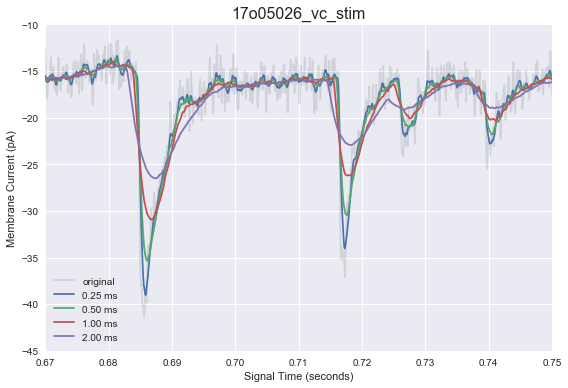

In [6]:
abf.gaussianSigma=0 # disable filtering
abf.setSweep(5)
plt.plot(abf.dataX,abf.dataY,label='original',alpha=.1,color='k')

for sigmaMS in [.25,.5,1,2]:
    abf.gaussianSigma=abf.pointsPerMS*sigmaMS # enable filtering
    abf.setSweep(5)
    plt.plot(abf.dataX,abf.dataY,label='%.02f ms'%(sigmaMS))
    
abf.plotDecorate(legend=True,axis=[0.67,.75,-45,-10])

### Half vs. full Gaussian filtering

**By default, the Gaussian filter is set to half (right, forward-only) filtering.** You probably will never need a "whole" or "left" Gaussian filter, but it's documented here just in case. Sometimes you want to lowpass filter in the time domain, but you don't want to pollute the rising edge of features like EPSCs and IPSCs. For this, a half-gaussian filtering is preferred. This takes the gaussian kernel, sets one half of it to zero, and convolves the data against this half-gaussian kernel. It is set by assigning `True` or `False` to `abf.gaussianLeft` and `abf.gaussianRight`. If both are `False` a full kernel is used. If both are `True` an exception is thrown.

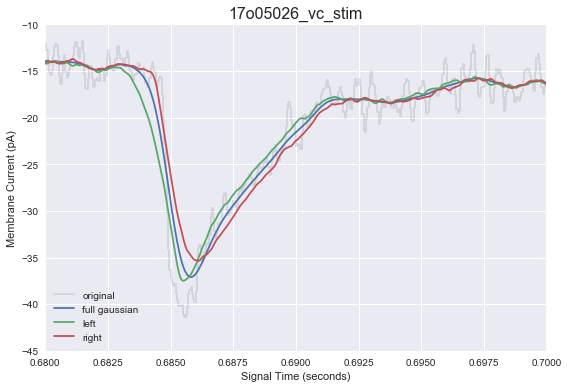

In [15]:
# ORIGINAL DATA
abf.gaussianSigma=0 # gaussian filtering off
abf.setSweep(5)
plt.step(abf.dataX,abf.dataY,label='original',alpha=.1,color='k')

# FULL GAUSSIAN
abf.gaussianSigma=abf.pointsPerMS/2
abf.gaussianLeft=False
abf.gaussianRight=False
abf.setSweep(5)
plt.plot(abf.dataX,abf.dataY,label='full gaussian')

# HALF GAUSSIAN (LEFT)
abf.gaussianSigma=abf.pointsPerMS/2
abf.gaussianLeft=True
abf.gaussianRight=False
abf.setSweep(5)
plt.plot(abf.dataX,abf.dataY,label='left')

# HALF GAUSSIAN (RIGHT)
abf.gaussianSigma=abf.pointsPerMS/2
abf.gaussianLeft=False
abf.gaussianRight=True
abf.setSweep(5)
plt.plot(abf.dataX,abf.dataY,label='right')

abf.plotDecorate(legend=True,axis=[0.68,.7,-45,-10])

**What's the difference?** It's subtle, but notice that with an EPSC-like shape (sharper rise, slower decay), the right-gaussian preserves the sharpness of the sharp rise more than the whole-gaussian and both more than the left-gaussian. This means for derivative-based event detection, right-gaussian filtering is preferred for EPSC/IPSC-like events.

The left Gaussian is pretty useless and should never be used. The _right_ Gaussian has sharper rise times (as compared to the full gaussian). If you desire to perform event dectection on IPSCs or EPSCs, a right Gaussian filter may be preferred because it smooths the data but preserves sharp large rises and falls.

## Averaging sweeps together
* TODO

## Measuring the average (or stdev/stderr)
_Values are measured by sweep between two time points_

In [16]:
abf=pyabf.abf.ABF("../data/17o05024_vc_steps.abf") # this ABF is useful for measurements

### Between time points
Calculate average value between seconds 0.75 and 1.00 for every sweep:

_NOTE: `abf.average()`, `abf.stderr()` and `abf.stdev()` all work the same way_

In [17]:
avgs = np.empty(abf.sweepCount)
for sweep in abf.sweepList:
    avgs[sweep] = abf.average(setSweep=sweep, t1=.75, t2=1)
print(avgs, abf.units)

[-48.937 -40.768 -35.256 -28.167 -23.118 -18.401 -13.58 ] pA


### By epoch
Calculate the average value of epoch B:

In [18]:
avgs = np.empty(abf.sweepCount)
for sweep in abf.sweepList:
    avgs[sweep] = abf.averageEpoch(epoch=1,setSweep=sweep)
print(avgs, abf.units)

[-49.889 -42.509 -35.996 -28.746 -23.724 -17.189 -11.696] pA


Calculate the average value of the last 25% of epoch B:

In [19]:
avgs = np.empty(abf.sweepCount)
for sweep in abf.sweepList:
    avgs[sweep] = abf.averageEpoch(epoch=1,setSweep=sweep,lastFrac=.25)
print(avgs, abf.units)

[-50.089 -41.723 -35.707 -27.975 -23.253 -17.979 -13.317] pA


_(the same thing can be done with `firstFrac`)_

## Decorating a Matplotlib graph

`abf.decorate()` has a lot of optional arguments and tries to make it easy to tweak a matplotlib figure to display ephys data. For starters, look at what the default arguments do:

In [20]:
# set sweep and filter to make it look nice
abf.setSweep(0)
abf.gaussianSigma=abf.pointsPerMS

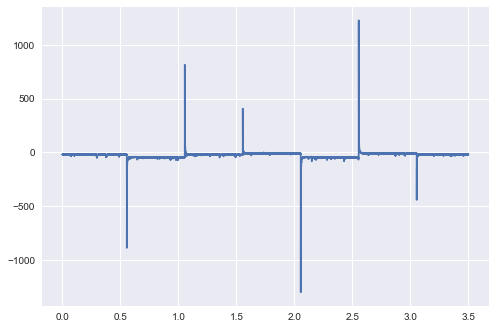

In [21]:
plt.plot(abf.dataX,abf.dataY); # default plot, WITHOUT using abf.decorate()

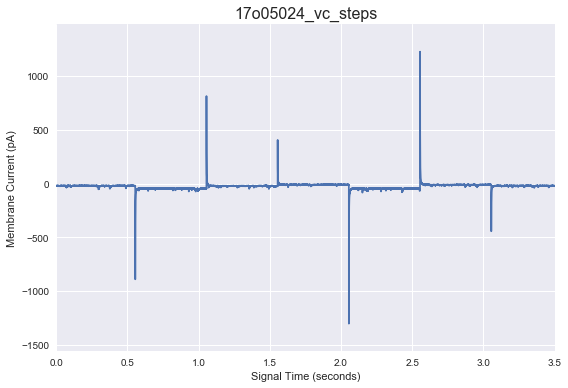

In [22]:
plt.plot(abf.dataX,abf.dataY)
abf.plotDecorate() # adds title and axis labels, and adjust data margins

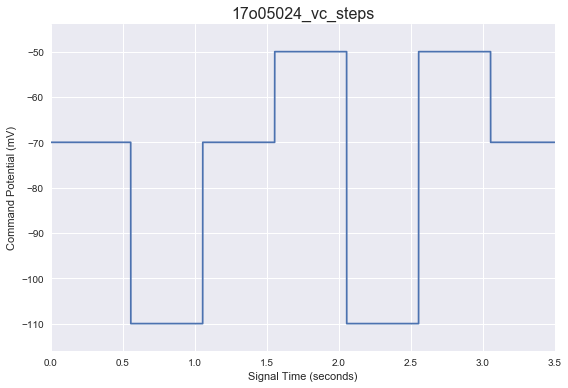

In [23]:
plt.plot(abf.dataX,abf.dataC) # plotting the command signal (not the trace signal)
abf.plotDecorate(command=True) # decorate for the command signal (note the units difference)

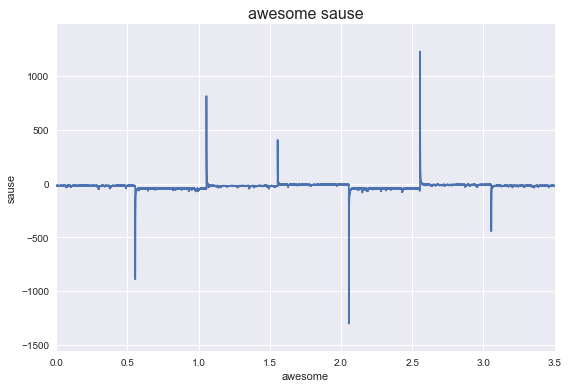

In [24]:
plt.plot(abf.dataX,abf.dataY)
abf.plotDecorate(title="awesome sause",xlabel="awesome",ylabel="sause")

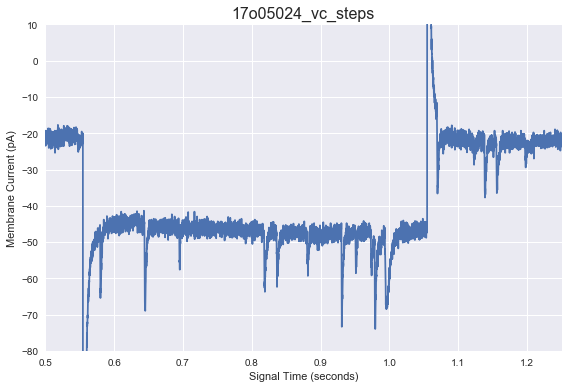

In [29]:
plt.plot(abf.dataX,abf.dataY)
abf.plotDecorate(axis=[.5,1.25,-80,10]) # manually define axis limits

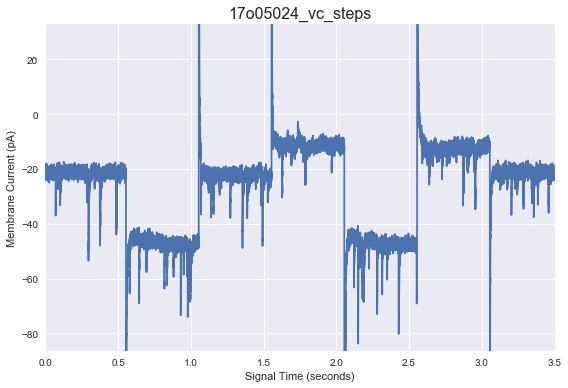

In [30]:
plt.plot(abf.dataX,abf.dataY)
abf.plotDecorate(zoomYstdev=2) # automatically set Y axis limits to 2x the stdev of the data

## Plotting Sweeps
For most uses you should probably write your own sweep plotting function. If you're messing around and want a shortcut, this will work.

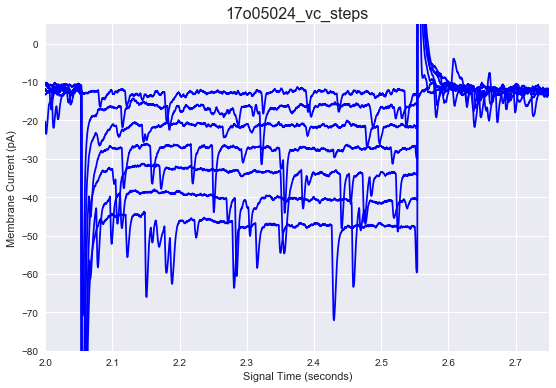

In [32]:
abf.plotSweeps() # plot all sweeps
abf.plotDecorate()
plt.axis([2,2.75,-80,5]); # zoom in on an interesting area

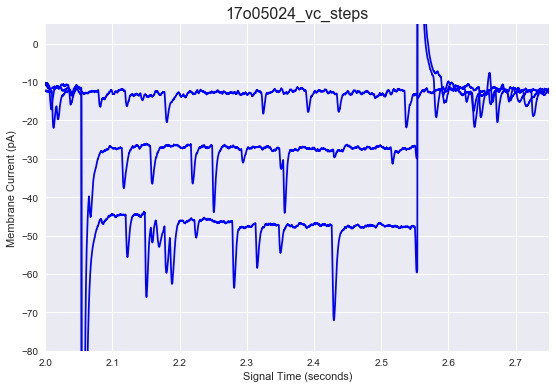

In [33]:
abf.plotSweeps([0,3,-1]) # plot specific sweeps
abf.plotDecorate()
plt.axis([2,2.75,-80,5]); # zoom in on an interesting area

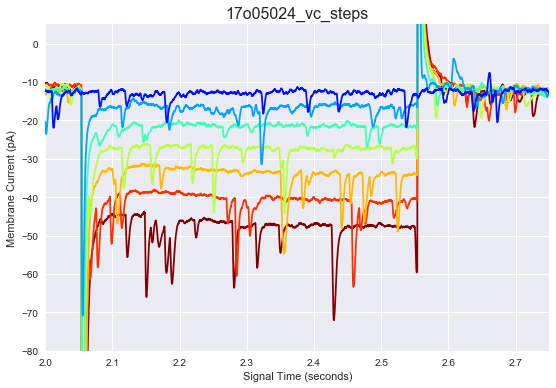

In [34]:
abf.plotSweeps(useColormap=True)
abf.plotDecorate()
plt.axis([2,2.75,-80,5]);

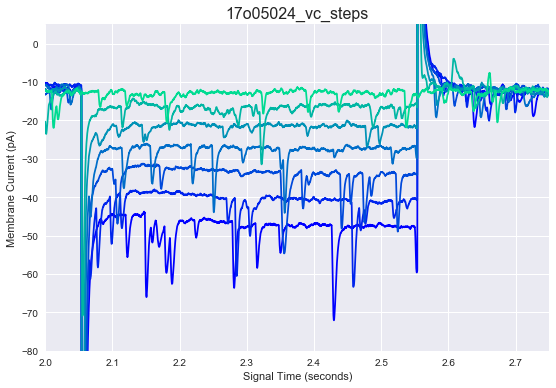

In [35]:
abf.colormap="winter" # you can change the colormap
abf.plotSweeps(useColormap=True)
abf.plotDecorate()
plt.axis([2,2.75,-80,5]);

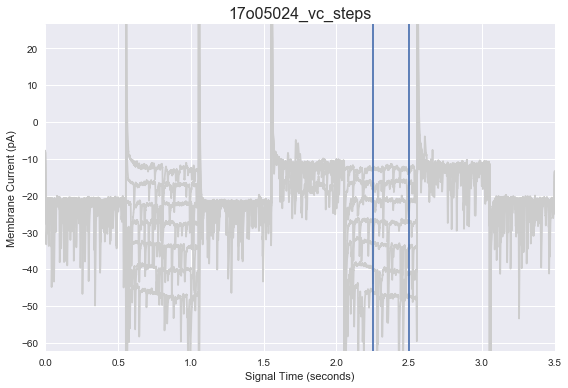

In [36]:
# Quick way to inspect where some marks are you may be interested in
abf.plotSweeps(color='.8')
mark1,mark2=2.25,2.50
plt.axvline(mark1)
plt.axvline(mark2)
abf.plotDecorate(zoomYstdev=5)

## Epoch inspection

In [37]:
# Load an ABF we are interested in 
abf=pyabf.abf.ABF("../data/17o05024_vc_steps.abf")
abf.gaussianSigma=10
abf.setSweep(2)

Epoch A, B, C... (number 0, 1, 2...) can be inspected rapidly with `abf.plotEpochs`:

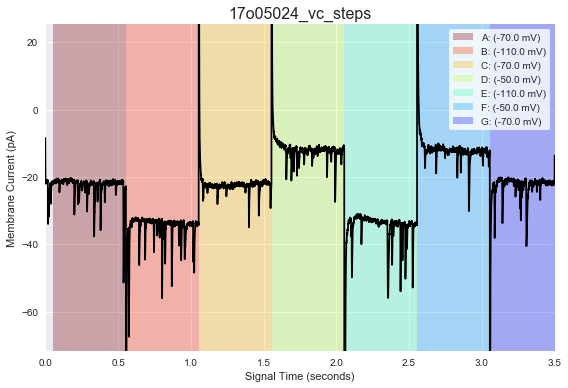

In [38]:
abf.plotEpochs()
plt.legend(frameon=True,facecolor='w');

_Notice that the first 1/64'th of the sweep is pre-epoch signal and therefore not shaded_

## Create an IV curve (vltage-clamp)

First let's look at the area we are interested in.

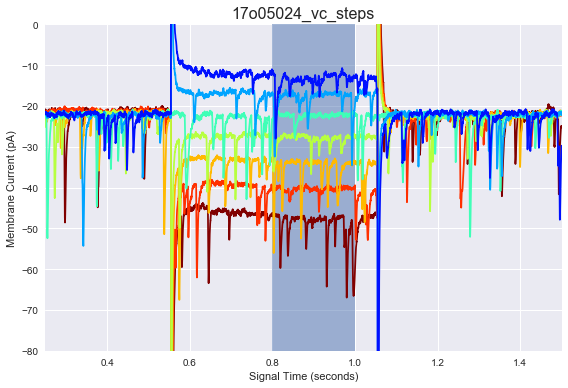

In [40]:
abf.plotSweeps(useColormap=True)
abf.plotDecorate(axis=[.25,1.5,-80,0])
mark1,mark2=.8,1.0
plt.axvspan(mark1,mark2,alpha=.5);

We know this is epoch B (epoch 1) from our graph above, so let's get the command voltages for Epoch B and get the average between the marks using the `abf.average()` method we reviewed above:

In [41]:
epochNumber=1
voltages=np.empty(abf.sweepCount)
currents=np.empty(abf.sweepCount)
for sweep in abf.sweepList:
    abf.setSweep(sweep)
    voltages[sweep]=abf.epochCommand[epochNumber]+abf.epochCommandDelta[epochNumber]*sweep
    currents[sweep]=abf.average(t1=mark1,t2=mark2)
print(voltages,abf.unitsCommand)
print(currents,abf.units)

[-110. -100.  -90.  -80.  -70.  -60.  -50.] mV
[-49.488 -40.437 -35.588 -28.392 -22.412 -18.358 -13.808] pA


Plotting one against the other becomes trivial

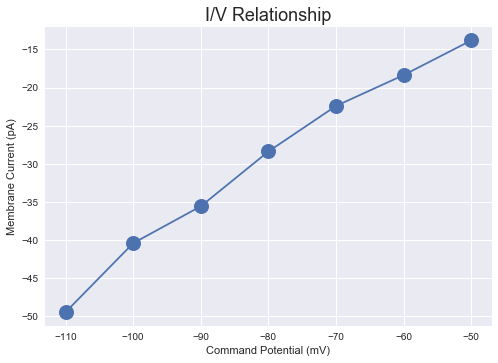

In [42]:
plt.plot(voltages,currents,'.-',ms=30)
plt.ylabel(abf.unitsLong)
plt.xlabel(abf.unitsCommandLong)
plt.title("I/V Relationship",fontsize=18);

## Reading epoch values without `abf.setSweep()`

`abf.setSweep()` is slow because it loads data (sometimes even gaussian filtering it). `abf.epochCommand` and `abf.epochCommandDelta` are only updated when you `abf.setSweep()`. If you ever just want the command values, pull them directly from the `ABFheader` class object (`abf._abfHeader.header`)

In [43]:
epochNumber=1
voltages=np.empty(abf.sweepCount)
for sweep in abf.sweepList:
    voltages[sweep]=abf._abfHeader.header['fEpochInitLevel'][epochNumber]+\
                    abf._abfHeader.header['fEpochLevelInc'][epochNumber]*sweep
print(voltages,abf.units)

[-110. -100.  -90.  -80.  -70.  -60.  -50.] pA


What all is available in the `abf._abfHeader.header` dictionary? To find out, run:

```python
abf._abfHeader.show()
```